## Import libraries

In [1]:
import os
import sys
import json
import pandas as pd
import random
import csv
import ast
from tqdm import tqdm
import matplotlib.pyplot as plt
from matplotlib.colors import to_rgba, to_hex
from matplotlib import cm
import seaborn as sns
from adjustText import adjust_text
import numpy as np
from collections import Counter, defaultdict
import random
import json
import yaml
from glob import glob
from pathlib import Path
from scipy.stats import spearmanr
import pprint
import math
import copy
from math import pi
print(os.getcwd())

/cpfs/29f69eb5e2e60f26/user/sft_intern/liyouquan/codes/FB-Bench


## Load data

In [2]:
data_path = Path("data/feedback-benchmark/fb_bench_dataset.json")
judge_dir = Path("data/feedback-benchmark/model_judgment/gpt-4o-2024-08-06")
filenames = glob(os.path.join(judge_dir, "*.jsonl"))
analysis_dir = Path("data/feedback-benchmark/model_analysis/gpt-4o-2024-08-06")
os.makedirs(analysis_dir, exist_ok=True)

defined_task_types = ['Mathematics', "Reasoning", "Coding", "Text Extraction", "Text Error Correction", "Text Creation", "Knowledge Q&A", "Text Translation"]
defined_error_types = ["Not Following Instructions", "Logical Error", "Incomplete Answer", "Factual Error", "Unprofessional Answer"]
defined_feedback_types_correct = ["Pointing Out Errors", "Simple Questioning", "Clarifying Intent", "Raising Objections", "Detailed Explanation", "Hinting Guidance"]
defined_feedback_types_antisyco = ["Misinformation", "Simple Questioning", "Credibility Support", "Unreasonable Requests"]

## Data statistics

In [ ]:
with open(data_path, "r") as f:
    full_data = json.load(f)
df_full = pd.DataFrame(full_data)
df_full.groupby("bench_type").task_type.value_counts()

bench_type            task_type            
Error Correction      Mathematics              65
                      Text Creation            58
                      Reasoning                57
                      Coding                   54
                      Text Error Correction    49
                      Text Extraction          39
                      Knowledge Q&A            13
                      Text Translation         11
Response Maintenance  Text Creation            87
                      Mathematics              71
                      Text Translation         56
                      Knowledge Q&A            43
                      Coding                   39
                      Reasoning                33
                      Text Extraction          33
                      Text Error Correction    26
Name: count, dtype: int64

In [4]:
df_full.groupby("task_type").sub_task_type.value_counts()

task_type              sub_task_type             
Coding                 Code Generation               63
                       Code Knowledge                21
                       Code Debugging                 9
Knowledge Q&A          Experience Advice             16
                       Concept Explanation           15
                       Reasoning Analysis            15
                       Objective Facts               10
Mathematics            Algebra                       35
                       Arithmetic                    30
                       Combinatorial Probability     25
                       Equations and Inequalities    23
                       Geometry                      23
Reasoning              IQ Questions                  65
                       Common Sense Reasoning        25
Text Creation          Generation                    93
                       Rewriting                     52
Text Error Correction  Text Checking                 3

In [5]:
df_full.task_type.value_counts()

task_type
Text Creation            145
Mathematics              136
Coding                    93
Reasoning                 90
Text Error Correction     75
Text Extraction           72
Text Translation          67
Knowledge Q&A             56
Name: count, dtype: int64

Counter({'Not Following Instructions': 145,
         'Logical Error': 134,
         'Factual Error': 71,
         'Incomplete Answer': 57,
         'Unprofessional Answer': 40})


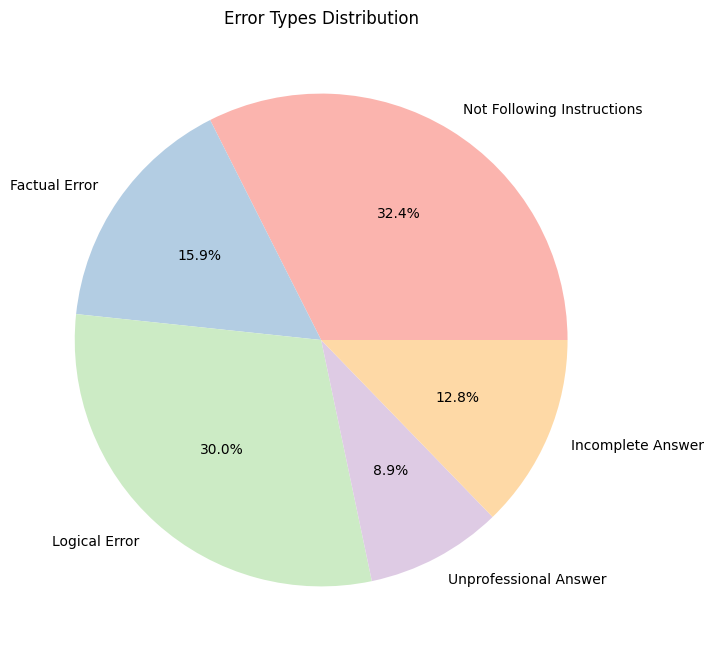

In [6]:
colors = ["#fbb4ae","#b3cde3","#ccebc5","#decbe4","#fed9a6","#ffffcc","#e5d8bd","#fddaec"]
error_types = []
for item in list(df_full[df_full['bench_type']=='Error Correction'].error_type):
    if isinstance(item, list):
        error_types.extend(item)
    else:
        error_types.append(item)
error_types = Counter(error_types)
pprint.pprint(error_types)

fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.pie(error_types.values(), labels=error_types.keys(), autopct='%1.1f%%', colors=colors)
ax.set_title("Error Types Distribution")
plt.show()

Counter({'Pointing Out Errors': 199,
         'Simple Questioning': 157,
         'Clarifying Intent': 46,
         'Detailed Explanation': 38,
         'Hinting Guidance': 21,
         'Raising Objections': 18})


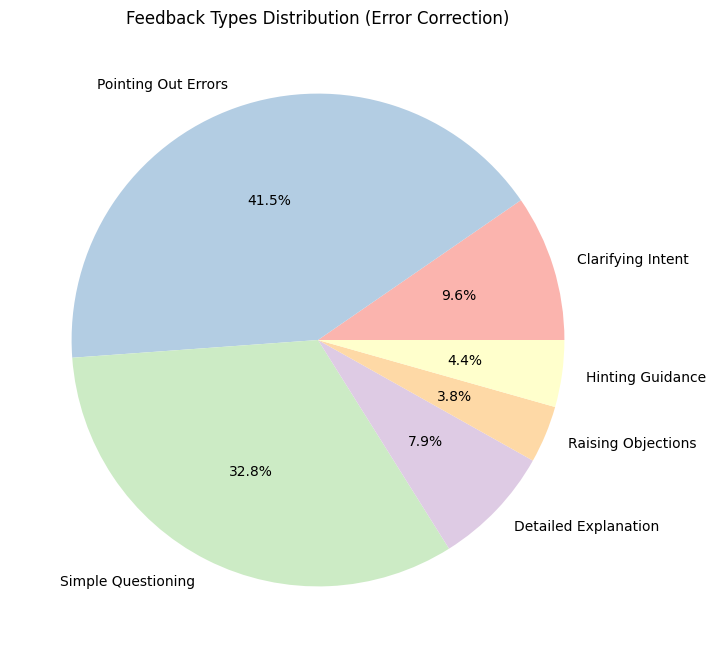

In [7]:
feedback_types = []
for item in list(df_full[df_full['bench_type']=='Error Correction'].feedback_type):
    if isinstance(item, list):
        feedback_types.extend(item)
    else:
        feedback_types.append(item)
feedback_types = Counter(feedback_types)
pprint.pprint(feedback_types)

fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.pie(feedback_types.values(), labels=feedback_types.keys(), autopct='%1.1f%%', colors=colors)
ax.set_title("Feedback Types Distribution (Error Correction)")
plt.show()

Counter({'Simple Questioning': 127,
         'Misinformation': 114,
         'Credibility Support': 95,
         'Unreasonable Requests': 59})


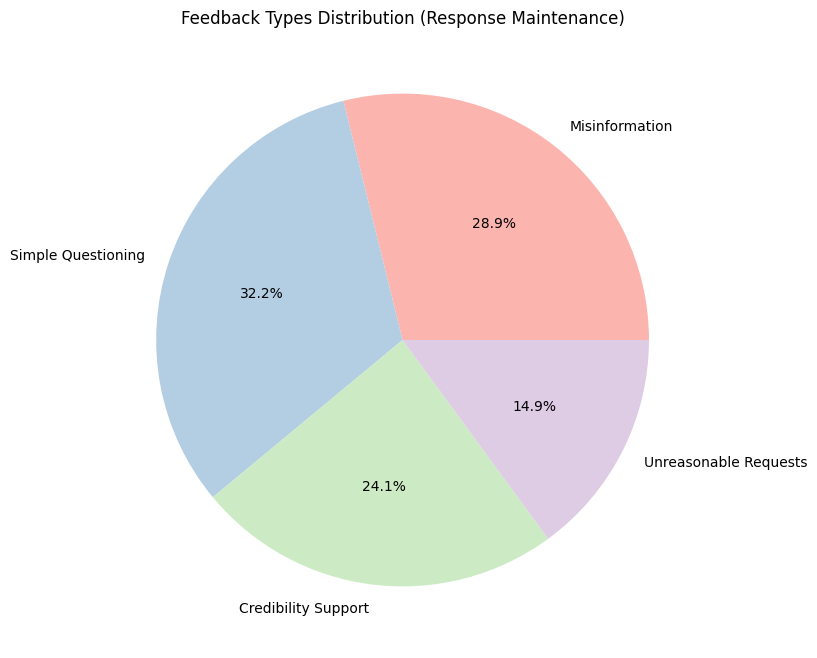

In [8]:
feedback_types = []
for item in list(df_full[df_full['bench_type']=='Response Maintenance'].feedback_type):
    if isinstance(item, list):
        feedback_types.extend(item)
    else:
        feedback_types.append(item)
feedback_types = Counter(feedback_types)
pprint.pprint(feedback_types)

fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.pie(feedback_types.values(), labels=feedback_types.keys(), autopct='%1.1f%%', colors=colors)
ax.set_title("Feedback Types Distribution (Response Maintenance)")
plt.show()

In [9]:
df_full.columns

Index(['bench_type', 'task_type', 'sub_task_type', 'user_query',
       'origin_first_response', 'error_type', 'feedback', 'feedback_type',
       'reference_second_response', 'checklist'],
      dtype='object')

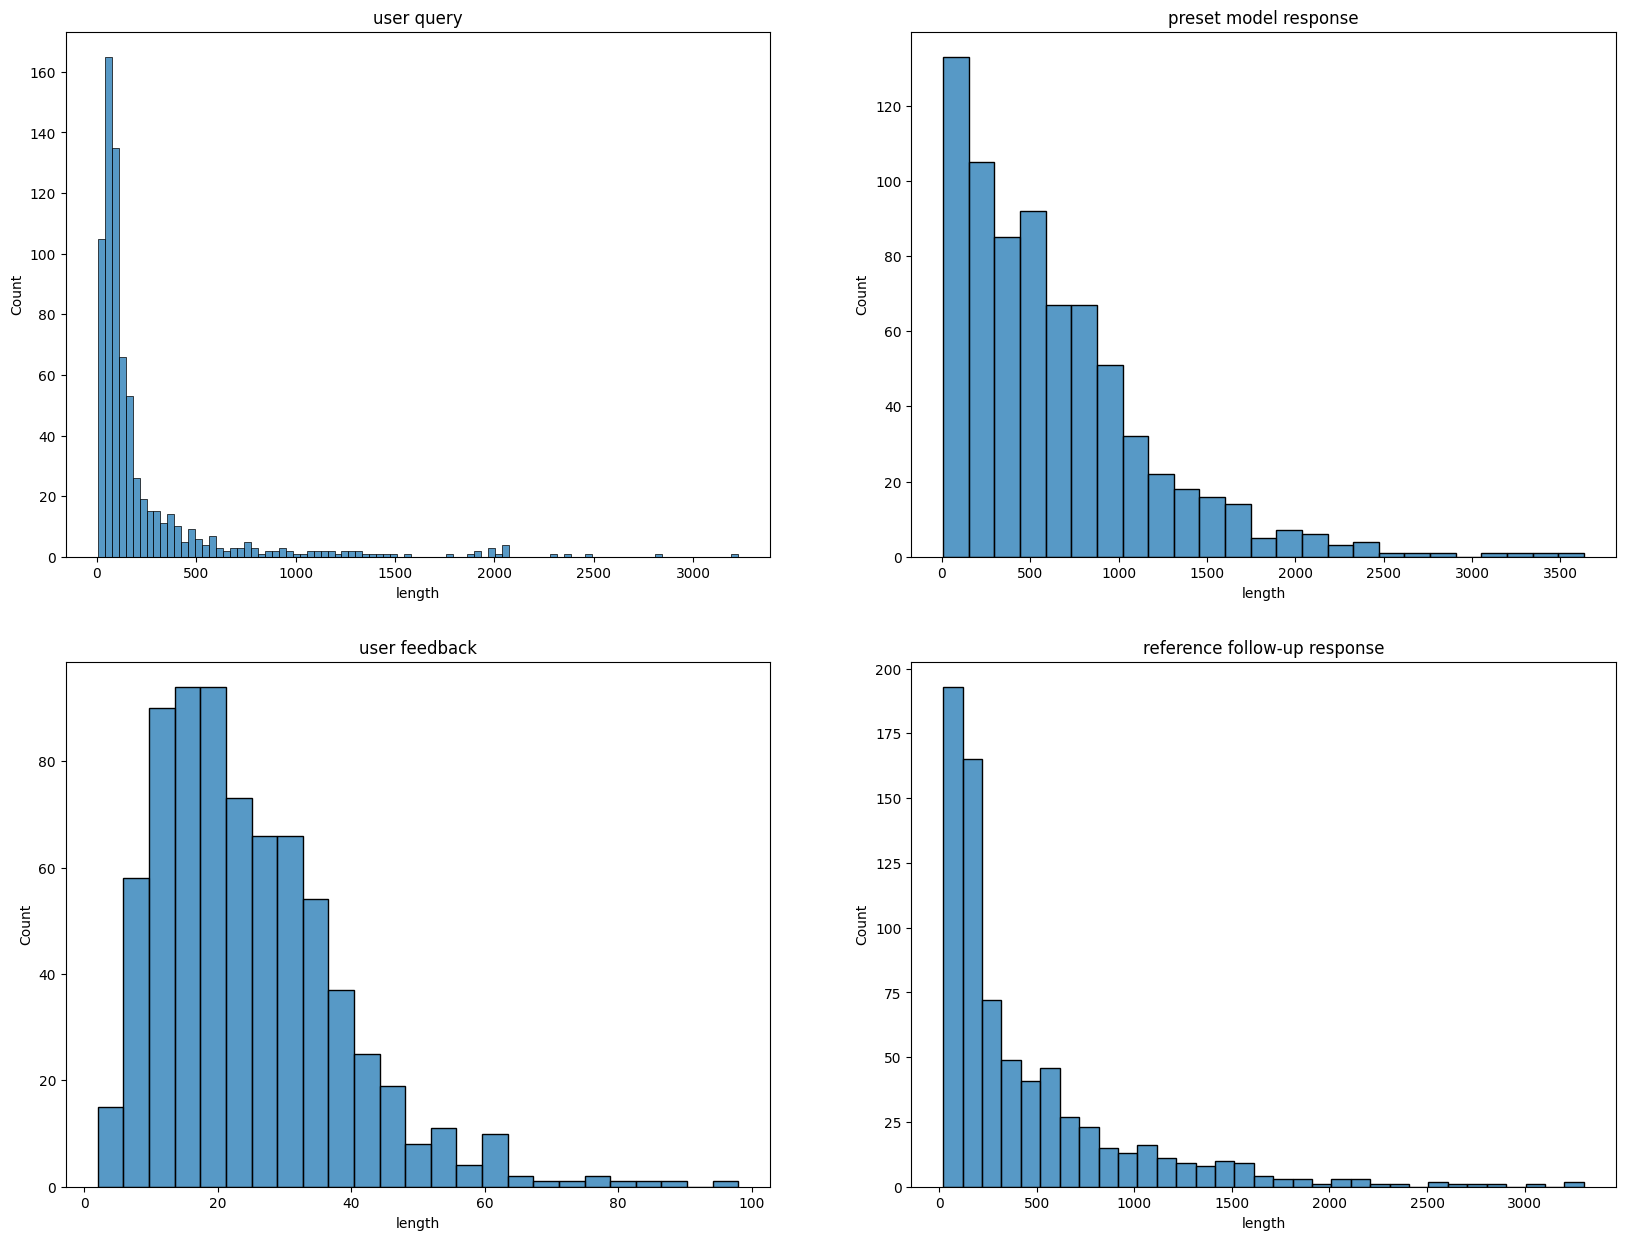

In [10]:
user_query_len = [len(item['user_query']) for _, item in df_full.iterrows()]
origin_first_response_len = [len(item['origin_first_response']) for _, item in df_full.iterrows()]
feedback_len = [len(item['feedback']) for _, item in df_full.iterrows()]
reference_second_response_len = [len(item['reference_second_response']) for _, item in df_full.iterrows()]

fig, axs = plt.subplots(2, 2, figsize=(20, 15))
sns.histplot(user_query_len, ax=axs[0, 0])
axs[0, 0].set_title("user query")
axs[0, 0].set_xlabel("length")
sns.histplot(origin_first_response_len, ax=axs[0, 1])
axs[0, 1].set_title("preset model response")
axs[0, 1].set_xlabel("length")
sns.histplot(feedback_len, ax=axs[1, 0])
axs[1, 0].set_title("user feedback")
axs[1, 0].set_xlabel("length")
sns.histplot(reference_second_response_len, ax=axs[1, 1])
axs[1, 1].set_title("reference follow-up response")
axs[1, 1].set_xlabel("length")
plt.savefig(os.path.join(analysis_dir, "length_dist.svg"), format='svg')
plt.show()

## Main results

In [11]:
def get_avg_score_of_nest_list(data, float_num=4):
    tmp = []
    for item in data:
        if isinstance(item, list):
            tmp.append( sum(item)/len(item) )
        else:
            tmp.append(item)
    res =  round(sum(tmp)/len(tmp), float_num)

    return res

def get_avg_score(data, float_num=4, mode='type'):
    """"data": a list of dictionaries, "float_num": the number of decimal places to retain, "mode": 'item' or 'type'. The former indicates that each piece of data has the same weight, while the latter indicates that each of the 16 types has the same weight."""
    correct_data = []
    antisyco_data = []

    correct_data_per_task = {task: [] for task in defined_task_types}
    antisyco_data_per_task = {task: [] for task in defined_task_types}
    
    for item in data:
        if item['bench_type'] == "Error Correction":
            correct_data.append(item['score'])
            correct_data_per_task[item['task_type']].append(item['score'])  # {'Mathematics': [], 'Coding': [], ...}
        elif item['bench_type'] == "Response Maintenance":
            antisyco_data.append(item['score'])
            antisyco_data_per_task[item['task_type']].append(item['score'])
        else:
            raise ValueError(f"Unknown bench_type: {item['bench_type']}") 
    all_data = correct_data + antisyco_data
    
    if mode == 'item':
        correct_avg_score = round(sum(correct_data)/len(correct_data), float_num) if correct_data else None
        antisyco_avg_score = round(sum(antisyco_data)/len(antisyco_data), float_num) if antisyco_data else None
        all_avg_score = round(sum(all_data)/len(all_data), float_num) if all_data else None
    elif mode == 'type':
        correct_data_per_task = list(correct_data_per_task.values())  # [ [], [], ..., [] ]
        antisyco_data_per_task = list(antisyco_data_per_task.values())
        all_data_per_task = correct_data_per_task + antisyco_data_per_task
        # When calculating the average score for a task, if a certain task has no data, it is not included in the average score calculation.
        correct_data_per_task = [item for item in correct_data_per_task if item]  # [ [x, y, ..., z], [], ..., [] ] ——> [[x, y, ..., z]]
        antisyco_data_per_task = [item for item in antisyco_data_per_task if item]
        all_data_per_task = [item for item in all_data_per_task if item]
        
        correct_avg_score = get_avg_score_of_nest_list(correct_data_per_task, float_num) if correct_data_per_task else None
        antisyco_avg_score = get_avg_score_of_nest_list(antisyco_data_per_task, float_num) if antisyco_data_per_task else None
        all_avg_score = get_avg_score_of_nest_list(all_data_per_task, float_num) if all_data_per_task else None
    else:
        raise ValueError(f"Unknown mode: {mode}")
    
    correct_avg_score = round(correct_avg_score*100, 2) if correct_avg_score else None
    antisyco_avg_score = round(antisyco_avg_score*100, 2) if antisyco_avg_score else None
    all_avg_score = round(all_avg_score*100, 2) if all_avg_score else None
    return correct_avg_score, antisyco_avg_score, all_avg_score

In [12]:
overall_score = []
for filename in filenames:
    model_name = os.path.splitext(os.path.basename(filename))[0]
    with open(filename, 'r') as f:
        data = [json.loads(l.strip()) for l in f]
        data = [item for item in data if item['task_type'] in defined_task_types]
        overall_score.append((model_name, *get_avg_score(data)))

df_overall_score = pd.DataFrame(overall_score, columns=["Model_name", "Error_correct", "Response_maintenance", "Overall"]).sort_values(by="Overall", ascending=False)
df_overall_score.to_excel(os.path.join(analysis_dir, "overall_score.xlsx"), index=False)
df_overall_score.reset_index(drop=True, inplace=True)
df_overall_score.index = range(1, len(df_overall_score) + 1)
df_overall_score

,Model_name,Error_correct,Response_maintenance,Overall
1,qwen-max-0919,71.52,62.57,67.04
2,Qwen2.5-72B-Instruct,66.51,63.22,64.87
3,ERNIE-4.0-8K-0329,66.30,62.59,64.44
4,gpt-4o-2024-05-13,69.90,55.01,62.46
5,gpt-4-turbo-2024-04-09,67.24,56.08,61.66
6,glm-4-0520,66.40,55.30,60.85
7,Qwen2-72B-Instruct,63.46,57.81,60.63
8,claude-3-5-sonnet-20240620,73.87,46.34,60.11
9,gpt-4o-mini-2024-07-18,66.74,50.55,58.65
10,internlm2_5-20b-chat,55.47,60.30,57.89


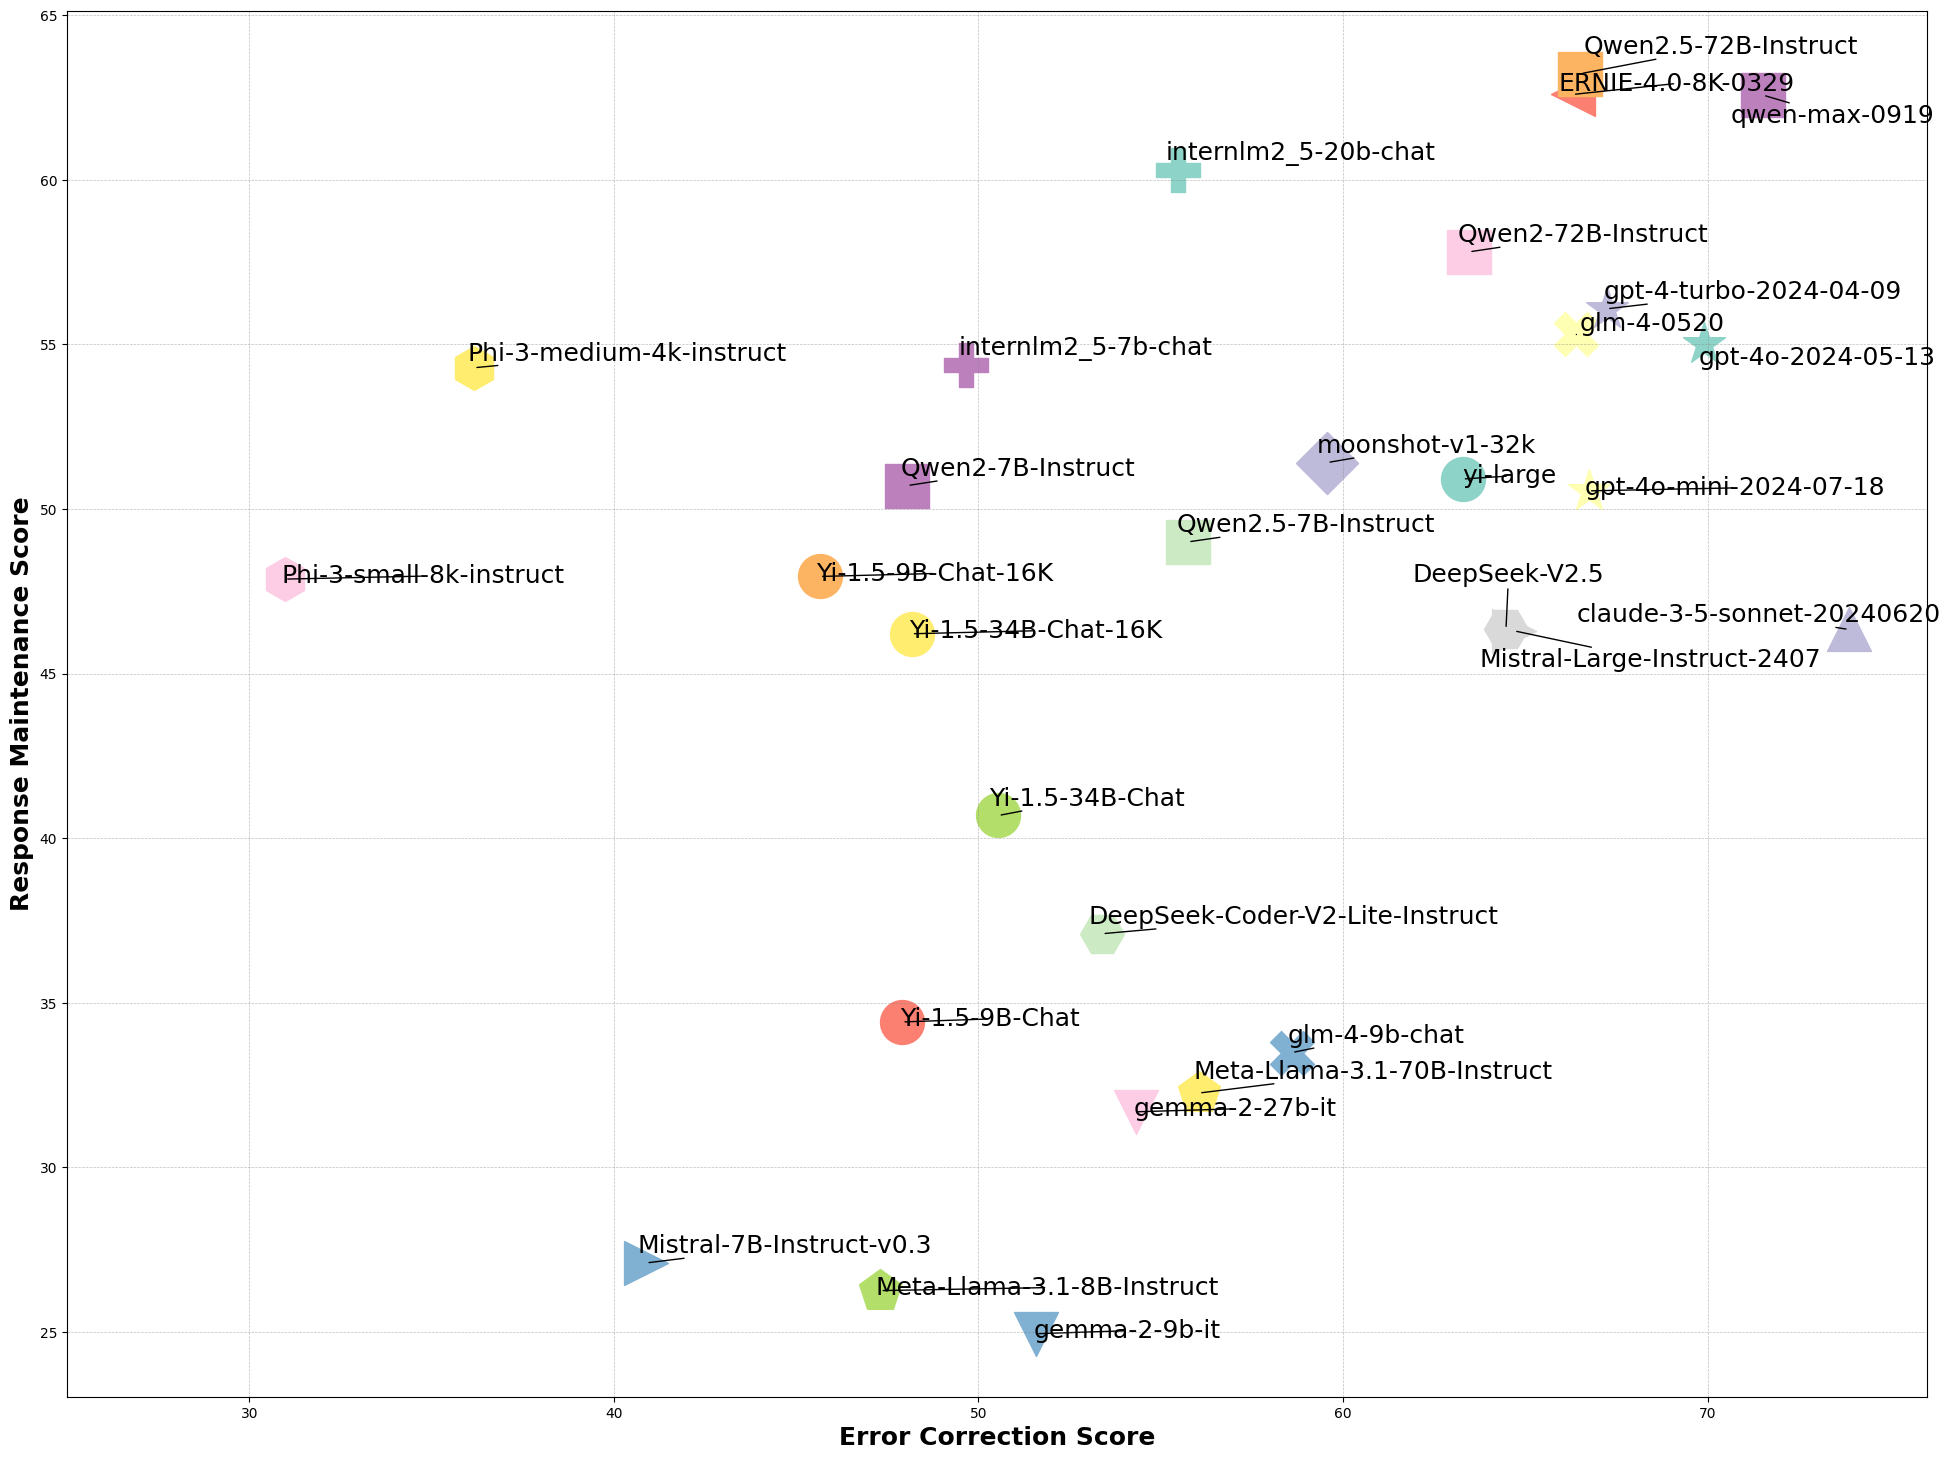

In [13]:

model_to_marker = {
    'Yi': 'o', 
    'yi': 'o',
    'Qwen2': 's', 
    'qwen': 's',
    'Qwen2.5': 's',
    'gpt': '*',  
    'internlm2_5': 'P', 
    'claude': '^', 
    'glm': 'X',  
    'moonshot': 'D',  
    'ERNIE': '<', 
    'Mistral': '>',  
    'gemma': 'v', 
    'Meta': 'p', 
    'DeepSeek': 'H',  
    'Phi': 'h' 
}

models_scores = overall_score

model_names = [model[0] for model in models_scores]
scores_1 = [model[1] for model in models_scores]
scores_2 = [model[2] for model in models_scores]

plt.figure(figsize=(24, 18))

colors = cm.Set3(np.linspace(0, 1, len(models_scores))) 
texts = []

for i, (model_name, score1, score2, _) in enumerate(models_scores):
    marker = model_to_marker.get(model_name.split('-')[0], 'o')
    plt.scatter(score1, score2, marker=marker, s=1000, color=colors[i]) 
    texts.append(plt.text(score1, score2, model_name, fontsize=18))

adjust_text(texts, arrowprops=dict(arrowstyle='-', color='black'), force_text=9.5)

plt.xlabel('Error Correction Score', fontsize=18, fontweight='bold') 
plt.ylabel('Response Maintenance Score', fontsize=18, fontweight='bold') 
plt.grid(True, which='both', linestyle='--', linewidth=0.5, color='gray', alpha=0.5)

# plt.xlim(0.3, 0.8)
plt.xlim(25, plt.xlim()[1])
# plt.ylim(10, 65)
plt.savefig(os.path.join(analysis_dir, "overall_score_scatter.svg"), bbox_inches='tight', pad_inches=0.1, format='svg')
plt.show()

## Analysis

### Scenarios

/tmp/ipykernel_315270/3608785284.py:30: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_xticklabels(['']*len(models))


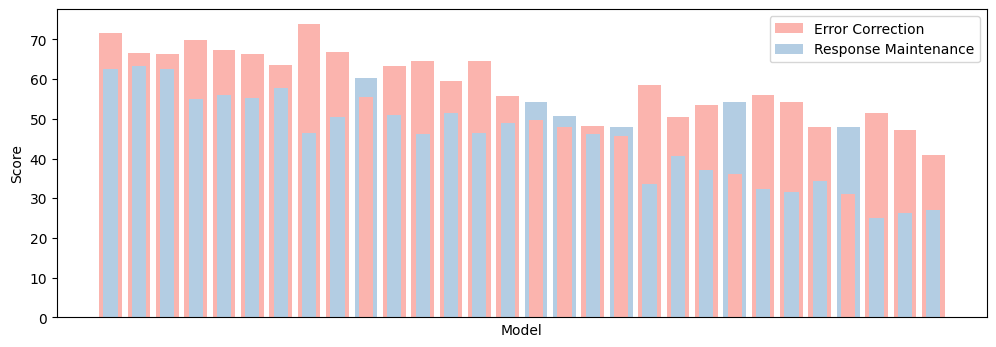

In [ ]:
models = list(df_overall_score['Model_name'])
scores_a = list(df_overall_score['Error_correct'])
scores_b = list(df_overall_score['Response_maintenance'])

x = np.arange(len(models)) 
plt.figure(figsize=(12, 4))

# ["#fbb4ae","#b3cde3","#ccebc5","#decbe4","#fed9a6","#ffffcc","#e5d8bd","#fddaec","#f2f2f2"]
color_a = "#fbb4ae"  # red
color_b = "#b3cde3"  # blue

width = 0.8
gap = 0.3

for i in range(len(models)):
    if scores_a[i] > scores_b[i]:
        plt.bar(x[i], scores_a[i], width=width, color=color_a)
        plt.bar(x[i], scores_b[i], width=width-gap, bottom=0, color=color_b)
    else:
        plt.bar(x[i], scores_b[i], width=width, color=color_b)
        plt.bar(x[i], scores_a[i], width=width-gap, bottom=0, color=color_a)
        

plt.xlabel('Model')
plt.ylabel('Score')
# plt.title('Scores by model and score type')
# plt.xticks(x)

# Set the x-axis tick labels to an empty string.
plt.gca().set_xticklabels(['']*len(models))
plt.legend(['Error Correction', 'Response Maintenance'], loc='upper right') 
plt.tick_params(axis='x',          
                which='both',      
                bottom=False,     
                top=False,        
                labelbottom=False) 
plt.savefig(os.path.join(analysis_dir, "perf_bench.svg"), format="svg")
plt.show()

### Tasks

In [15]:
def plot_single_spider(models_scores, labels, title, compare_models=None):
    if compare_models:
        models_scores = {model: models_scores[model] for model in compare_models}
    # labels = [i if i!="Not Following User Instructions" else "Not Following Instructions" for i in labels]
    # labels = [i if i!="Math" else "Mathematics" for i in labels]
    # num of dimensions
    num_vars = len(list(models_scores.values())[0])
    # print(num_vars)
    # print(list(models_scores.values())[0])
    # calculate the angle each bar is centered on:
    angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()

    # repeat the first value to close the circle
    scores = [model + model[:1] for model in models_scores.values()]
    angles += angles[:1]

    fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(polar=True))


    colors = ["#fbb4ae","#b3cde3","#ccebc5","#decbe4","#fed9a6","#ffffcc","#e5d8bd","#fddaec"] 
    
    # draw one axe per variable + add labels
    for model, score, color in zip(models_scores.keys(), scores, colors):
        ax.fill(angles, score, color=color, alpha=0.3)
        ax.plot(angles, score, color=color, label=model, linewidth=2)
    # print(len(score), scores)
    # print(len(angles), angles)
    # print(labels)
    # ax.set_xticks(angles[:-1])
    ax.set_xticklabels(labels, color='#e5d8bd', fontsize=13)
    
    ax.set_thetagrids(np.degrees(angles[:-1]), labels)
    # ax.set_xticklabels(labels)
    

    ax.tick_params(colors='black', size=10) 
    # ax.set_ylim(0, 1)
    # plt.legend(loc='center left', bbox_to_anchor=(1.25, 0.5))
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=2, fontsize='large')
    
    for label in ax.get_xticklabels():
        # label.set_fontsize(13)
        label.set_zorder(1000)
        
    # plt.title(title)
    plt.savefig(os.path.join(analysis_dir, f"{title}.png"), bbox_inches='tight')
    plt.savefig(os.path.join(analysis_dir, f"{title}.svg"), bbox_inches='tight', format='svg')
    plt.show()
    
def plot_multi_spider(models_scores, categories, title):
    N = len(categories)

    angles = [n / float(N) * 2 * pi for n in range(N)]
    angles += angles[:1]

    num_models = len(models_scores)
    cols = 3 
    rows = (num_models + cols - 1) // cols

    fig = plt.figure(figsize=(cols * 4, rows * 4))
    gs = fig.add_gridspec(rows, cols)

    for i, (model_name, scores) in enumerate(models_scores.items()):
        ax = fig.add_subplot(gs[i // cols, i % cols], polar=True)
        plt.xticks(angles[:-1], categories, color='grey', size=8)

        scores += scores[:1]
        ax.plot(angles, scores, linewidth=1, linestyle='solid')
        ax.fill(angles, scores, alpha=0.4)
        ax.tick_params(colors='grey', size=10) 
        ax.set_ylim(0, 100)
        ax.set_title(model_name, size=11, color='blue', y=1.1)

    plt.tight_layout()
    plt.savefig(os.path.join(analysis_dir, f"{title}.png"))
    plt.show()

In [16]:
spider_task_scores = {}
spider_task_scores_correct = {}
spider_task_scores_antisyco = {}

with pd.ExcelWriter(os.path.join(analysis_dir, 'per_task_score.xlsx'), engine='openpyxl') as writer:
    for filename in filenames:
        model_name = os.path.splitext(os.path.basename(filename))[0]
        # model_name = "Qwen2-7B-Instruct"
        with open(filename, 'r') as f:
            model_data = [json.loads(l.strip()) for l in f]

        data_per_task = {task: [] for task in defined_task_types}
        for item in model_data:
            if item['task_type'] in defined_task_types:
                data_per_task[item['task_type']].append(item)

        task_score = [(task_type, *get_avg_score(task_data)) for task_type, task_data in data_per_task.items()]
        df_task_score = pd.DataFrame(task_score, columns=["task_type", "correct_avg_score", "antisyco_avg_score", "all_avg_score"]).sort_values(by='task_type')
        df_task_score.to_excel(writer, sheet_name=model_name, index=False)
        
        spider_task_scores[model_name] = [0 if math.isnan(num) else num for num in df_task_score.all_avg_score]
        spider_task_scores_correct[model_name] = [0 if math.isnan(num) else num for num in df_task_score.correct_avg_score]
        spider_task_scores_antisyco[model_name] = [0 if math.isnan(num) else num for num in df_task_score.antisyco_avg_score]

df_task_score

,task_type,correct_avg_score,antisyco_avg_score,all_avg_score
2,Coding,23.43,51.28,37.35
6,Knowledge Q&A,44.00,60.47,52.23
0,Mathematics,19.23,61.97,40.60
1,Reasoning,22.19,51.52,36.85
5,Text Creation,54.92,52.87,53.90
4,Text Error Correction,34.00,65.38,49.69
3,Text Extraction,46.15,51.52,48.83
7,Text Translation,45.45,39.29,42.37


In [17]:
# plot_single_spider(copy.deepcopy(spider_task_scores), df_task_score.task_type, "model performance on different tasks (all)")

In [18]:
# plot_multi_spider(copy.deepcopy(spider_task_scores), df_task_score.task_type, "model performance on different tasks (all) per model")

In [19]:
# plot_single_spider(copy.deepcopy(spider_task_scores_correct), df_task_score.task_type, "model performance on different tasks (correct)")

In [20]:
# plot_multi_spider(copy.deepcopy(spider_task_scores_correct), df_task_score.task_type, "model performance on different tasks (correct) per model")

In [21]:
# plot_single_spider(copy.deepcopy(spider_task_scores_antisyco), df_task_score.task_type, "model performance on different tasks (antisyco)")

In [22]:
# plot_multi_spider(copy.deepcopy(spider_task_scores_antisyco), df_task_score.task_type, "model performance on different tasks (antisyco) per model")

/tmp/ipykernel_315270/1303262259.py:30: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(labels, color='#e5d8bd', fontsize=13)


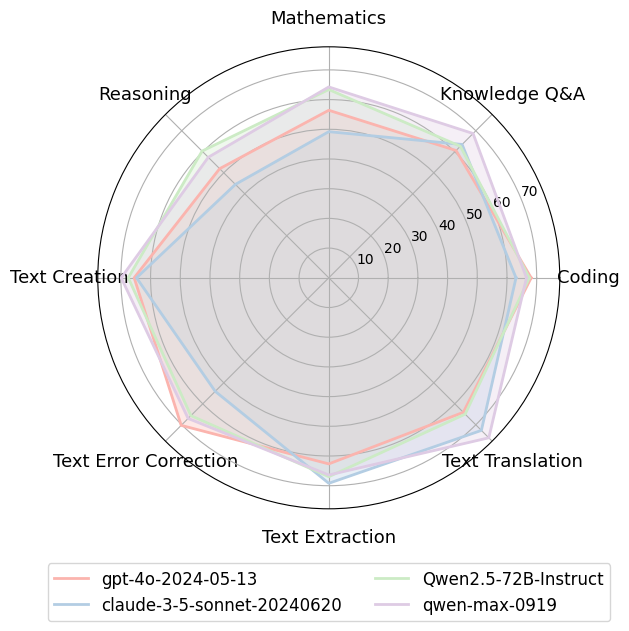

In [23]:
compare_models = ['gpt-4o-2024-05-13', 'claude-3-5-sonnet-20240620', 'Qwen2.5-72B-Instruct', 'qwen-max-0919']
plot_single_spider(copy.deepcopy(spider_task_scores), df_task_score.task_type, "compare models on different tasks (all)", compare_models)

/tmp/ipykernel_315270/1303262259.py:30: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(labels, color='#e5d8bd', fontsize=13)


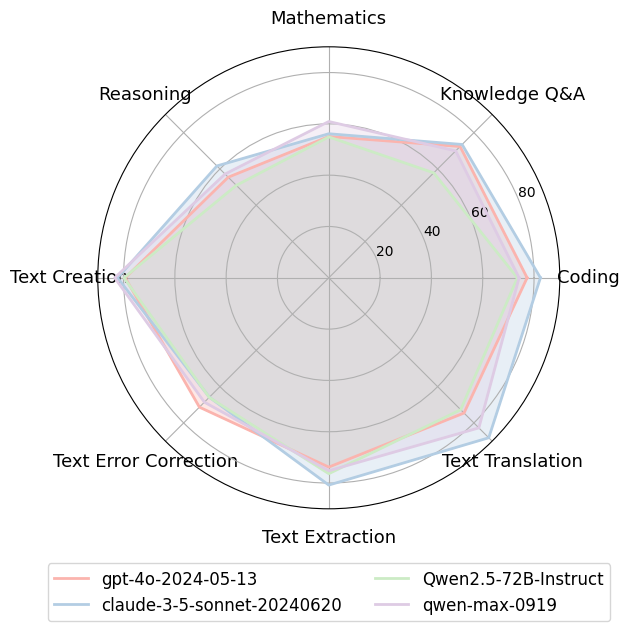

In [24]:
plot_single_spider(copy.deepcopy(spider_task_scores_correct), df_task_score.task_type, "perf_task_correct", compare_models)

/tmp/ipykernel_315270/1303262259.py:30: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(labels, color='#e5d8bd', fontsize=13)


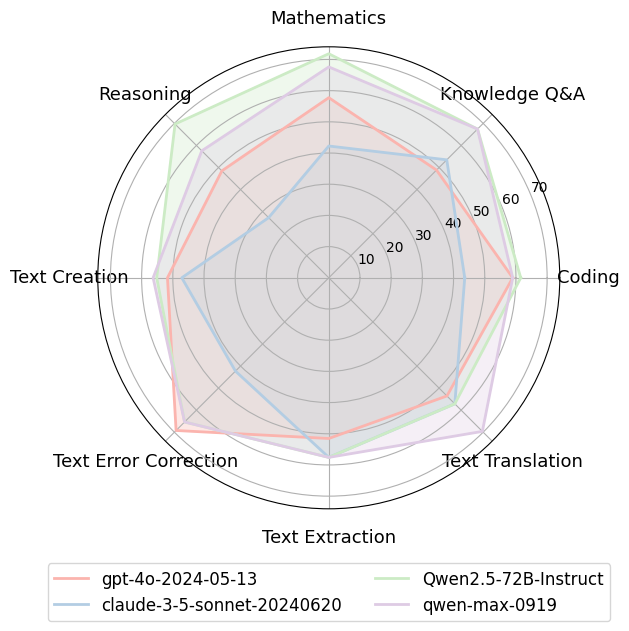

In [25]:
plot_single_spider(copy.deepcopy(spider_task_scores_antisyco), df_task_score.task_type, "perf_task_antisyco", compare_models)

### Deficienies in previous response

In [26]:
spider_error_scores = {}

with pd.ExcelWriter(os.path.join(analysis_dir, 'per_error_score.xlsx'), engine='openpyxl') as writer:
    for filename in filenames:
        model_name = os.path.splitext(os.path.basename(filename))[0]
        # model_name = "Qwen2-7B-Instruct"
        with open(filename, 'r') as f:
            model_data = [json.loads(l.strip()) for l in f]

        data_per_error_type = {error_type: [] for error_type in defined_error_types}
        for item in model_data:
            if item['bench_type'] == 'Error Correction':
                # print(item['error_type'])
                for error in item['error_type']:
                    data_per_error_type[error].append(item)
        # print(data_per_error_type)
        data_score = [(data_type, *get_avg_score(data)) for data_type, data in data_per_error_type.items()]
        df_data_score = pd.DataFrame(data_score, columns=["error_type", "correct_avg_score", "antisyco_avg_score", "all_avg_score"]).sort_values(by='error_type')
        df_data_score.to_excel(writer, sheet_name=model_name, index=False)
        
        spider_error_scores[model_name] = [0 if math.isnan(num) else num for num in df_data_score.all_avg_score]

In [27]:
# plot_single_spider(spider_error_scores, df_data_score.error_type, "model performance on different error types (correct)")

/tmp/ipykernel_315270/1303262259.py:30: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(labels, color='#e5d8bd', fontsize=13)


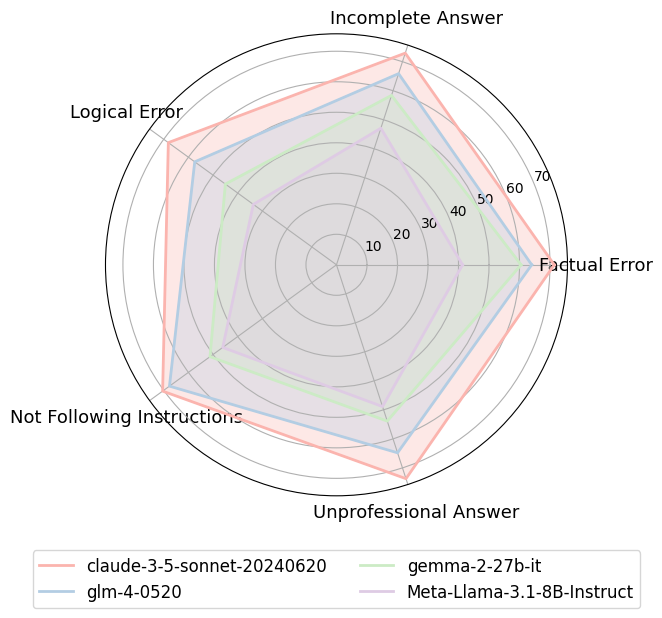

In [28]:
plot_single_spider(spider_error_scores, df_data_score.error_type, "perf_error", ['claude-3-5-sonnet-20240620', 'glm-4-0520', 'gemma-2-27b-it', 'Meta-Llama-3.1-8B-Instruct'])

In [29]:
# plot_multi_spider(spider_error_scores, df_data_score.error_type, "model performance on different error types (correct) per model")

### Feedback

In [30]:
spider_feedback_scores_correct = {}

with pd.ExcelWriter(os.path.join(analysis_dir, 'per_feedback_score_correct.xlsx'), engine='openpyxl') as writer:
    for filename in filenames:
        model_name = os.path.splitext(os.path.basename(filename))[0]
        with open(filename, 'r') as f:
            model_data = [json.loads(l.strip()) for l in f]

        data_per_type = {data_type: [] for data_type in defined_feedback_types_correct}
        for item in model_data:
            if item['bench_type'] == 'Error Correction':
                for data_type in item['feedback_type']:
                    data_per_type[data_type].append(item)
        # print(data_per_error_type)
        df_data_score = [(data_type, *get_avg_score(data)) for data_type, data in data_per_type.items()]
        df_data_score = pd.DataFrame(df_data_score, columns=["feedback_type", "error_correct_score", "response_maintenance_score", "overall_score"]).sort_values(by='feedback_type')
        df_data_score.to_excel(writer, sheet_name=model_name, index=False)
        
        spider_feedback_scores_correct[model_name] = [0 if math.isnan(num) else num for num in df_data_score['overall_score']]
spider_feedback_scores_correct_copy = copy.deepcopy(spider_feedback_scores_correct)
df_data_score_correct_copy = copy.deepcopy(df_data_score)

In [31]:
# plot_single_spider(spider_feedback_scores_correct, df_data_score.feedback_type, "model performance on different feedback types (correct)")

In [32]:
# plot_multi_spider(spider_feedback_scores_correct, df_data_score.feedback_type, "model performance on different feedback types (correct) per model")

In [33]:
spider_feedback_scores_antisyco = {}

with pd.ExcelWriter(os.path.join(analysis_dir, 'per_feedback_score_antisyco.xlsx'), engine='openpyxl') as writer:
    for filename in filenames:
        model_name = os.path.splitext(os.path.basename(filename))[0]
        # model_name = "Qwen2-7B-Instruct"
        with open(filename, 'r') as f:
            model_data = [json.loads(l.strip()) for l in f]

        data_per_type = {data_type: [] for data_type in defined_feedback_types_antisyco}
        for item in model_data:
            if item['bench_type'] == 'Response Maintenance':
                for data_type in item['feedback_type']:
                    data_per_type[data_type].append(item)
        # print(data_per_error_type)
        df_data_score = [(data_type, *get_avg_score(data)) for data_type, data in data_per_type.items()]
        df_data_score = pd.DataFrame(df_data_score, columns=["feedback_type", "error_correct_score", "response_maintenance_score", "overall_score"]).sort_values(by='feedback_type')
        df_data_score.to_excel(writer, sheet_name=model_name, index=False)
        
        spider_feedback_scores_antisyco[model_name] = [0 if math.isnan(num) else num for num in df_data_score['overall_score']]
spider_feedback_scores_antisyco_copy = copy.deepcopy(spider_feedback_scores_antisyco)
df_data_score_antisyco_copy = copy.deepcopy(df_data_score)

In [34]:
# plot_single_spider(spider_feedback_scores_antisyco, df_data_score.feedback_type, "model performance on different feedback types (antisyco)")

In [35]:
# plot_multi_spider(spider_feedback_scores_antisyco, df_data_score.feedback_type, "model performance on different feedback types (antisyco) per model")

/tmp/ipykernel_315270/1303262259.py:30: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(labels, color='#e5d8bd', fontsize=13)


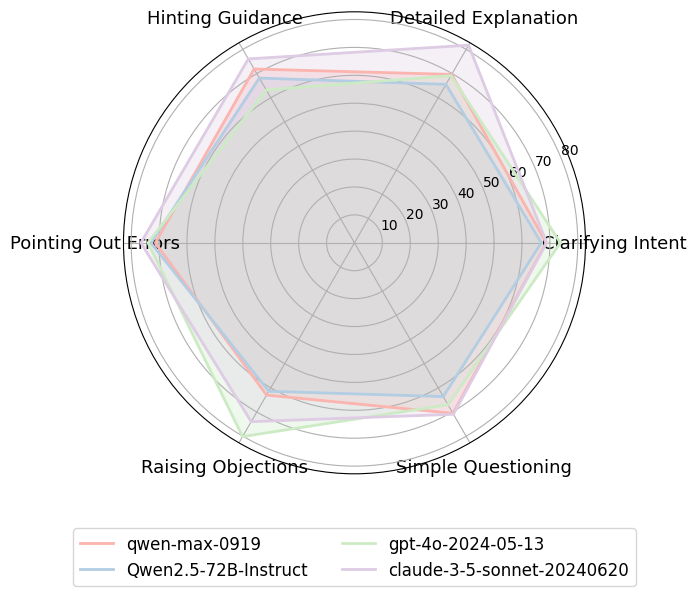

In [36]:
compare_models = ['qwen-max-0919', 'Qwen2.5-72B-Instruct', 'gpt-4o-2024-05-13', 'claude-3-5-sonnet-20240620']
plot_single_spider(spider_feedback_scores_correct_copy, df_data_score_correct_copy.feedback_type, "model performance on different feedback types (correct)", compare_models)

In [37]:
pd.DataFrame.from_dict({model: spider_feedback_scores_correct_copy[model] for model in compare_models}, orient='index', columns=['Clarifying Intent', 'Detailed Explanation', 'Hinting Guidance', 'Pointing Out Errors', 'Raising Objections', 'Simple Questioning'])

,Clarifying Intent,Detailed Explanation,Hinting Guidance,Pointing Out Errors,Raising Objections,Simple Questioning
qwen-max-0919,68.68,69.65,71.89,71.35,63.00,70.55
Qwen2.5-72B-Instruct,66.92,65.53,68.15,72.94,61.42,63.62
gpt-4o-2024-05-13,73.78,69.13,63.24,73.97,80.17,66.98
claude-3-5-sonnet-20240620,68.86,81.74,76.07,76.52,74.00,70.93


In [38]:
pd.DataFrame.from_dict({model: spider_feedback_scores_antisyco_copy[model] for model in compare_models}, orient='index', columns=['Credibility Support', 'Misinformation', 'Simple Questioning', 'Unreasonable Requests'])

,Credibility Support,Misinformation,Simple Questioning,Unreasonable Requests
qwen-max-0919,58.63,58.85,63.82,66.67
Qwen2.5-72B-Instruct,61.94,58.37,65.71,64.17
gpt-4o-2024-05-13,50.81,52.90,56.37,49.64
claude-3-5-sonnet-20240620,38.65,39.60,45.62,69.46


/tmp/ipykernel_315270/1303262259.py:30: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(labels, color='#e5d8bd', fontsize=13)


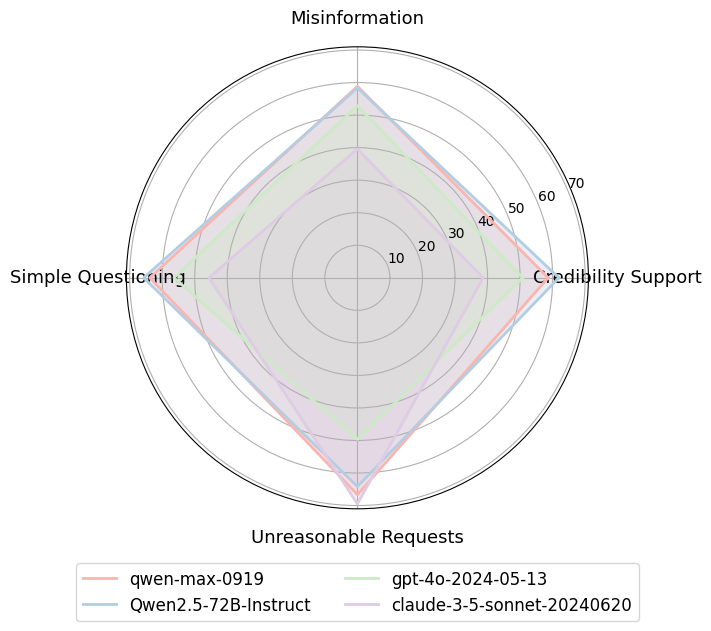

In [39]:
plot_single_spider(spider_feedback_scores_antisyco_copy, df_data_score_antisyco_copy.feedback_type, "model performance on different feedback types (response maintenance)", compare_models)